In [32]:
import matplotlib.pyplot as plt
import math

In [2]:
from __future__ import annotations

import os
from typing import TypeVar

import cv2 as cv
import numpy as np
import pywt

In [3]:
def wavelet_dec_red_rec(
    image: np.ndarray,
    level: int = 5,
    remove_to_small_scale_layer: int = -1,
    remove_large_scale: bool = True,
) -> np.ndarray:
    # decomposition
    coeffs = pywt.wavedec2(image, 'db8', level=level)
    # reduction
    for n in tuple(range(remove_to_small_scale_layer, 0)):
        for i in tuple(range(0, 3)):
            coeffs[n][i].fill(0)
    if remove_large_scale:
        coeffs[0].fill(0)
    # reconstruction
    return pywt.waverec2(coeffs, 'db8')


T = TypeVar('T')


def iof(l: collections.abc.Sequence[T], i: int) -> T:
    # index overflow / circular linked list
    while True:
        if -1 < i < len(l):
            break
        else:
            i -= (i // len(l)) * len(l)
    return l[i]


def mash(image, struc_range_low=None, struc_range_high=None):
    image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)  # grayscale
    image_blur = cv.GaussianBlur(image_gray, (9, 9), 0, 0)  # blur

    image_b_float = image_blur.astype(np.float32) / np.iinfo(image_blur.dtype).max
    image_float = image_gray.astype(np.float32) / np.iinfo(image_gray.dtype).max

    image_b_wlred = wavelet_dec_red_rec(image_b_float)
    image_wlred = wavelet_dec_red_rec(image_float)
    # threshold
    image_b_binary = cv.threshold(
        (t := image_b_wlred),
        t.min() + (t.max() - t.min()) * 0.4,
        255,
        cv.THRESH_BINARY,
    )[1].astype(np.uint8)

    # find contours
    image_contours = cv.findContours(image_b_binary, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)[0]
    image_stars: list[tuple[np.ndarray[float, float], float]] = []  # [( (x, y), intensity )]

    for c in image_contours:
        # calculate the centroid from clear image, to increase precision
        star_mask = cv.drawContours(
            np.zeros(image_wlred.shape, image_wlred.dtype),
            [c],
            0,
            1,
            cv.FILLED,
        )
        M = cv.moments(image_wlred * star_mask)
        centroid = np.array([M['m10'] / M['m00'], M['m01'] / M['m00']])
        # denote brightness from blur image, to increase robustness
        brightness = image_b_wlred[int(centroid[1]), int(centroid[0])]

        image_stars.append((centroid, brightness))
    image_stars.sort(key=lambda e: e[1], reverse=True)
    mean = np.array(tuple(e[1] for e in image_stars)).mean()
    for i in range(len(image_stars)):
        if image_stars[i][1] < mean:
            image_stars = image_stars[:i]
            break

    if struc_range_low is None:
        struc_range_low, struc_range_high = (
            np.array([0.1, 1])
            * np.array(
                tuple(np.linalg.norm(s[0] - image_stars[0][0]) for s in image_stars[1:])
            ).std()
        )

    image_structure: list[
        tuple[
            np.ndarray,  # S2A[x, y]; source star centroid
            np.ndarray,  # SNx2A[ [angle, ratio] ]; feature array
        ]
    ] = []

    for s1 in image_stars:
        neighbour: list[
            list[
                np.ndarray,  # [ S2A(separation vector) ]
                float,  # magnitude of separation vector
                float,  # angle from angle reference vector
            ]
        ] = []

        for s2 in image_stars:
            if struc_range_low < np.linalg.norm((sv := (s2[0] - s1[0]))) < struc_range_high:
                # populate separation vector and its magnitude
                neighbour.append([sv, (sr := np.linalg.norm(sv))])
                # Neighbour is already sorted by brightness because `refe_stars`
                # is sorted.  So the `neighbour[0][0]` is the angle reference vector.
                # populate angle from angle reference vector
                neighbour[-1].append(
                    np.arccos(np.clip(np.dot(neighbour[0][0], sv) / (neighbour[0][1] * sr), -1, 1))
                    * np.sign(np.cross(neighbour[0][0], sv))
                )
        # too few neighbour do not form enough triangles
        if len(neighbour) < 3:
            continue

        neighbour.sort(key=lambda e: e[2])
        feature: list[tuple[float, float]] = []  # [ (angle, ratio) ]
        for i1 in range(0, len(neighbour)):
            for i2 in range(i1 + 1, i1 + len(neighbour)):
                # here we may cross the 'PI, -PI' boundary, then `later - former`
                # becomes the clockwise angle (negative value), so we need to
                # prepare `later` to be greater
                later, former = iof(neighbour, i2)[2], neighbour[i1][2]
                if later < former:
                    later += 2 * np.pi
                angle = later - former
                # any angle less than PI is ok, but we take 4/5 PI
                if ((4 / 5) * np.pi) < angle:
                    break
                ratio = neighbour[i1][1] / iof(neighbour, i2)[1]
                feature.append((angle, ratio))

        image_structure.append((s1[0], np.array(feature)))

    return (
        image_gray,
        image_blur,
        image_wlred,
        image_b_wlred,
        image_b_binary,
        image_contours,
        image_stars,
        image_structure,
        struc_range_low,
        struc_range_high,
    )

In [4]:
# set tiff input folder
dir_input_tiff = os.path.normpath(
    os.path.join(
        os.getcwd(),
        '../',
        'input_tiff/size_full',
    )
)

# sort input files
tiff_list = os.listdir(dir_input_tiff)
tiff_list.sort()
# take the sequence middle as the reference frame
reference_tiff = tiff_list[len(tiff_list) // 2]
# and remove it from the 'to align' list
tiff_list.pop(len(tiff_list) // 2)

'__T_0523.TIF'

In [5]:
refe = cv.imread(
    os.path.join(dir_input_tiff, reference_tiff),
    cv.IMREAD_UNCHANGED,
)

In [86]:
tiff_list[0], tiff_list[-1]

('__T_0498.TIF', '__T_0547.TIF')

In [107]:
refe = cv.imread(
    os.path.join(dir_input_tiff, '__T_0547.TIF'),
    cv.IMREAD_UNCHANGED,
)

In [108]:
targ = cv.imread(
    os.path.join(dir_input_tiff, '__T_0498.TIF'),
    cv.IMREAD_UNCHANGED,
)

In [109]:
refe_gray, refe_blur, refe_wlred, refe_b_wlred, refe_b_binary, refe_contours, refe_stars, refe_structures, refe_struc_range_low, refe_struc_range_high = mash(refe)

In [110]:
targ_gray, targ_blur, targ_wlred, targ_b_wlred, targ_b_binary, targ_contours, targ_stars, targ_structures, _, _ = mash(targ, refe_struc_range_low, refe_struc_range_high)

In [111]:
len(refe_structures), len(targ_structures)

(134, 118)

- star match
    - star field structure
- star align
    - calculate transform matrix

## Star Match

### star field structure

- find brightest in refe
- calculate distance between brightest and all others
- cut a range in these distances
-
- for each star, find all stars within range
- calculate vector from source to target
- every two vector within angle PI form a triangle, fully characterized by the inner angle and the ratio of the two vector magnitudes (mind the order)
    - take brightest star as angle reference vector
    - for each vector, calculate angle from angle ref. vector (anticlockwise)
    - sort vectors by angle
    - (2 layer) iterate the list, take the anticlockwise angle (later minus former), ratio be the former divided by the later
- so the structure feature array `Sn` would be of the form: `[ Vector1Triangle0, V1T1, V1T2, V2T0, V2T1, V3T0, ... ]`, with each `VnTn` of the form: `[angle, ratio]`
-
- pick 2 structures if categorized as similar, treat the source as the same star
    - pick `S1[i1]` as start, iterate `S2` untile find a match `S2[i2]`
    - pick `S1[i1+1]`, start at `S2[i2+1]`, find match at `S2[i2+n1]`
    - do the same for `S1[i1+2]`, start at `S2[i2+n1+1]`, find match at `S2[i2+n1+n2]`

#### test area

In [ ]:
refe_stars[2], targ_stars[7]

In [ ]:
refe_structures[2][0], targ_structures[7][0]

okay ... by eyeball 2 and 7 are the same star, how to get this result from the feature array?

In [ ]:
refe_structures[2][1].shape, targ_structures[7][1].shape

In [ ]:
plt.scatter(*refe_structures[2][1].T)

In [ ]:
plt.scatter(*targ_structures[7][1].T)

try to represent 'correlation'

In [ ]:
distance = []
for r in refe_structures[2][1]:
    for t in targ_structures[7][1]:
        distance.append(np.linalg.norm(r - t))

In [ ]:
t = np.array(distance)

find the characteristic of matched star feature array

In [ ]:
t.std(), t.shape

In [ ]:
plt.hist(t, bins=100, range=(-0.01, 0.05))

find an appropriate function to 'weight' distance

In [ ]:
x = np.linspace(0, 0.1, 1000)

In [ ]:
y = 2 / ( 1 + np.exp(np.power((80*x), 3)) )
plt.plot(x, y)

test run

In [ ]:
score = 2 / ( 1 + np.exp(np.power((80*t), 3)) )

In [ ]:
score.sum() / (len(refe_structures[2][1]) + len(targ_structures[7][1]))

---
---

In [11]:
# def score_feature_correlation(
#     f1: np.ndarray,
#     f2: np.ndarray,
#     weight_cliff_coeff: int = 80,
# ) -> float:
#     separation: list[float] = []
#     for triangle_1 in f1:
#         for triangle_2 in f2:
#             separation.append(np.linalg.norm(triangle_2 - triangle_1))
#     s = np.array(separation)
#     normalized_separation = 2 / (1 + np.exp(
#         np.power( (weight_cliff_coeff * s), 3 )
#     ))
#     return normalized_separation.sum() / (len(f1) + len(f2))

def score_feature_correlation(
    # the order of `f1` and `f2` does not matter
    f1: np.ndarray,  # f1: SNx2A[ [angle, ratio] ]
    f2: np.ndarray,  # f2: SMx2A[ [angle, ratio] ]
    weight_cliff_coeff: int = 80,
) -> float:
    # prepare `f1` and `f2` to be in the 'cartesian product' shape 'S NMx2 A'
    f1e = np.repeat(f1, len(f2), axis=0)
    f2e = np.tile(f2, (len(f1), 1))

    separation = np.linalg.norm(f2e - f1e, axis=1)
    # normalized_separation = 2 / (
    #     1 + np.exp(np.power(weight_cliff_coeff * separation, 3))
    # )
    normalized_separation = np.divide(
        2,
        np.add(
            1,
            np.exp(
                np.power(
                    np.multiply(weight_cliff_coeff, separation),
                    3
                )
            )
        )
    )

    return normalized_separation.sum() / (len(f1) + len(f2))

test robustness and pick threshold

In [ ]:
tsl = []

In [ ]:
for source in refe_structures:
    for target in targ_structures:
        tsl.append(score_feature_correlation(source[1], target[1]))

In [ ]:
plt.hist(tsl, bins=200)

In [ ]:
plt.hist(tsl, bins=200, range=(0.1, 0.5))

In [ ]:
(len(refe_structures),
 len(targ_structures),
 len(tsl),
 len(tuple(e for e in tsl if 0.3 < e)))

---

In [12]:
def find_star_pair(
    reference_structures: list[tuple[
        np.ndarray,  # S2A[x, y]; star centroid
        np.ndarray,  # SNx2A[ [angle, ratio] ]; feature array
    ]],
    viewing_structures: list[tuple[np.ndarray, np.ndarray]],
    match_score_threshold: float = 0.3,
) -> list[tuple[
    np.ndarray, np.ndarray  # star centroid
]]:
    vs = viewing_structures.copy()
    refe_view_star_pair: list[tuple[np.ndarray, np.ndarray]] = []
    for r in reference_structures:
        match_list = []
        for iv in range(len(vs)):
            score = score_feature_correlation(r[1], vs[iv][1])
            if match_score_threshold < score:
                match_list.append( (vs[iv], iv, score) )
        if len(match_list) == 0:
            continue
        # sort `match_list` by score, descending
        match_list.sort(key=lambda e: e[2], reverse=True)
        # select highest score match
        refe_view_star_pair.append( (r[0], match_list[0][0][0]) )
        # remove selected match from search list
        vs.pop(match_list[0][1])
    # TODO: raise error if `not (4 < refe_view_star_pair)`
    return refe_view_star_pair

In [112]:
refe_targ_star_pair = find_star_pair(refe_structures, targ_structures)

<ipython-input-11-a32a4e6c6080>:34: RuntimeWarning: overflow encountered in exp
  np.exp(


In [113]:
len(refe_targ_star_pair)

91

## Star Align

prototype solve with sympy

In [ ]:
import sympy as syp

In [ ]:
xr, yr, xv, yv = syp.symbols(r'x_r, y_r, x_v, y_v', real=True)
m11, m12, m13 = syp.symbols(r'm_{11}, m_{12}, m_{13}', real=True)
m21, m22, m23 = syp.symbols(r'm_{21}, m_{22}, m_{23}', real=True)
m31, m32, m33 = syp.symbols(r'm_{31}, m_{32}, m_{33}', real=True)

In [ ]:
eq1 = (xr * (m31*xv + m32*yv + m33)) - (m11*xv + m12*yv + m13)
eq2 = (yr * (m31*xv + m32*yv + m33)) - (m21*xv + m22*yv + m23)

In [ ]:
eq1.expand()

In [ ]:
eq2.expand()

In [ ]:
ts = random.choices(refe_targ_star_pair, k=4)
eqs = []
for pair in ts:
    eqs.extend([
        eq1.subs([ (m33, 1), (xr, pair[0][0]), (xv, pair[1][0]), (yv, pair[1][1]) ]),
        eq2.subs([ (m33, 1), (yr, pair[0][1]), (xv, pair[1][0]), (yv, pair[1][1]) ]),
    ])

mij = syp.solve(
    eqs,
    (
        m11, m12, m13,
        m21, m22, m23,
        m31, m32,
    )
)
mij

---

In [156]:
def calculate_transformation_matrix(
    refe_view_star_pair: list[tuple[np.ndarray, np.ndarray]],
    sample_round: int = None,  # how many sample rounds, `None` for auto
) -> np.ndarray:  # should return an array of 9 numbers
    rng = np.random.default_rng()  # random number generator

    # auto determine sample round
    if sample_round is None:
        sample_round = len(refe_view_star_pair)**2
        # probability_of_not_all_coverage = 1 / 10**8
        # sample_round = 1 + int(math.log(
        #     probability_of_not_all_coverage,
        #     1 - 4/len(refe_view_star_pair)
        # ))

    mij: list[np.ndarray] = []  # list[ S9A[m_{ij}] ]
    for i in range(sample_round):
        # sample 4 star pairs to do one round calculation of matrix
        sample = rng.choice(
            refe_view_star_pair,
            size=4,
            replace=False,
            shuffle=False,
        )

        # xr*xv*m31 + xr*yv*m32 + xr*m33 - xv*m11 - yv*m12 - m13 = 0
        # yr*xv*m31 + yr*yv*m32 + yr*m33 - xv*m21 - yv*m22 - m23 = 0
        #
        # [ [xr*xv, xr*yv, xr, -xv, -yv, -1,   0,   0,  0],  X [ m31,  = [ 0,
        #   [yr*xv, yr*yv, yr,   0,   0,  0, -xv, -yv, -1] ]     m32,      0 ]
        #                                                        m33,
        #                                                        m11,
        #                                                        m12,
        #                                                        m13,
        #                                                        m21,
        #                                                        m22,
        #                                                        m23 ]
        #
        # 4 set of pairs and take `m33 = 1`, then we have `Ax=b` as:
        #
        # [ [xr*xv, xr*yv, xr, -xv, -yv, -1,   0,   0,  0],    [ m31,    [ 0, 
        #   [yr*xv, yr*yv, yr,   0,   0,  0, -xv, -yv, -1],      m32,      0, 
        #   [xr*xv, xr*yv, xr, -xv, -yv, -1,   0,   0,  0],      m33,      0, 
        #   [yr*xv, yr*yv, yr,   0,   0,  0, -xv, -yv, -1],      m11,      0, 
        #   [xr*xv, xr*yv, xr, -xv, -yv, -1,   0,   0,  0],  X   m12,  =   0, 
        #   [yr*xv, yr*yv, yr,   0,   0,  0, -xv, -yv, -1],      m13,      0, 
        #   [xr*xv, xr*yv, xr, -xv, -yv, -1,   0,   0,  0],      m21,      0, 
        #   [yr*xv, yr*yv, yr,   0,   0,  0, -xv, -yv, -1],      m22,      0, 
        #   [    0,     0,  1,   0,   0,  0,   0,   0,  0] ]     m23 ]     1 ]
        #
        # (actually recommend to put the `1` for `m33 = 1` on the last column,
        # otherwise numpy solve result might have float precision problem with
        # `m33`, e.g. fluctuate around `1.0`)
        #
        # ---
        #
        # [xr*xv, xr*yv, xr, -xv, -yv, -1,   0,   0,  0] == (
        #       [xr, xr, xr, -1, -1, -1, 0, 0, 0]
        #     * [xv, yv,  1, xv, yv,  1, 0, 0, 0]
        # )
        # [yr*xv, yr*yv, yr,   0,   0,  0, -xv, -yv, -1] == (
        #       [yr, yr, yr, 0, 0, 0, -1, -1, -1]
        #     * [xv, yv,  1, 0, 0, 0, xv, yv,  1]
        # )
        #
        # =>
        #
        # [ [xr*xv, xr*yv, xr, -xv, -yv, -1,   0,   0,  0],
        #   [yr*xv, yr*yv, yr,   0,   0,  0, -xv, -yv, -1] ]
        # ==
        # [ [xr, xr, xr, -1, -1, -1, 0, 0, 0],
        #   [yr, yr, yr, 0, 0, 0, -1, -1, -1] ]
        # *
        # [ [xv, yv, 1, xv, yv, 1,  0,  0, 0],
        #   [xv, yv, 1,  0,  0, 0, xv, yv, 1] ]

        # compose the `A` of `Ax=b`
        A1, A2 = [], []
        for p in sample:
            A1.extend([
                [ -1, -1, -1,     0, 0, 0,  p[0][0], p[0][0], p[0][0] ],
                [    0, 0, 0,  -1, -1, -1,  p[0][1], p[0][1], p[0][1] ]
            ])
            A2.extend([
                [ p[1][0], p[1][1], 1,              0, 0, 0,  p[1][0], p[1][1], 1 ],
                [             0, 0, 0,  p[1][0], p[1][1], 1,  p[1][0], p[1][1], 1 ]
            ])
        A1, A2 = np.array(A1), np.array(A2)

        # add extra row for `m33=1`
        A = np.vstack(
            (
                A1 * A2,
                np.hstack( (np.zeros((1, 8), dtype=int), np.array([[1]])) )
            )
        )

        # compose `b`
        b = np.hstack(
            ( np.zeros(8, dtype=int), np.array([1]) )
        )

        # solve for set of m_{ij} and append the result
        mij.append(np.linalg.solve(A, b))
    mij = np.array(mij)  # SNx9A[ [m_{ij}] ]; N = sample_round

    # mij might have a lot of outliers, aka large std,
    # we need to filter it before calculate its mean.
    # `vc` for 'validity_criterion'
    vc_max_std = 1
    vc_min_used_round = sample_round // 3

    fmij = mij.view()
    while vc_max_std < fmij.std(axis=0).max():
        # mean and std for each m_{ij} over all sets
        m, s = fmij.mean(axis=0), fmij.std(axis=0)  # S9A[m_{ij}]
        fmij = fmij[
            np.logical_or(  # SNx9A
                np.logical_and(  # SNx9A
                    # check for each m_{ij} in each set if it falls within m+-s
                    np.less_equal(m - s, fmij),
                    np.less_equal(fmij, m + s)
                ),
                # treat the result of `m33` as always valid, since it might
                # fluctuate around `1.0` very slightly (when not put at the
                # last column)
                np.hstack( (np.full(8, False), np.full(1, True)) )  # S9A
            # only keep sets that have all m_{ij} within m+-s
            ).all(axis=1)  # SNA
        ]
    if fmij.shape[0] < vc_min_used_round:
        raise Exception('Can not achieve valid transformation matrix.')

    # TODO: fmij seems to have two (or multiple?) very close peaks, and they
    # are not symmetric.  What could it be??
    return fmij#.mean(axis=0)

In [137]:
math.comb(len(refe_targ_star_pair), 4)

2672670

In [138]:
math.sqrt(2672670)

1634.8302664191167

In [150]:
mij1 = calculate_transformation_matrix(refe_targ_star_pair)
mij2 = calculate_transformation_matrix(refe_targ_star_pair, sample_round=10000)

In [151]:
mij1.mean(axis=0)[[2, 5]], mij1.std(axis=0)[[2, 5]], mij1.shape[0]

(array([154.19974796,  51.15971396]), array([0.56497854, 0.50827719]), 4966)

In [152]:
mij2.mean(axis=0)[[2, 5]], mij2.std(axis=0)[[2, 5]], mij2.shape[0]

(array([154.19784648,  51.16630984]), array([0.61039855, 0.54345692]), 6276)

(array([  3.,   4.,   8.,   0.,   2.,   1.,   1.,   2.,   3.,   2.,   4.,
          4.,   4.,   2.,   4.,   1.,   4.,   3.,   3.,   3.,   7.,   2.,
          1.,   4.,   1.,   8.,   6.,   3.,   5.,   3.,   4.,   6.,   6.,
          3.,   5.,   3.,   6.,   9.,   6.,   4.,   5.,   3.,   7.,  10.,
          6.,   6.,   7.,   4.,   9.,   9.,   3.,   7.,  15.,  11.,   9.,
          8.,   6.,  11.,  12.,  15.,  12.,   7.,  13.,  14.,  17.,  16.,
         18.,  13.,  22.,  22.,  13.,  25.,  26.,  24.,  27.,  33.,  30.,
         25.,  19.,  17.,  35.,  45.,  38.,  39.,  49.,  40.,  59.,  53.,
         88., 111.,  64.,  82.,  88.,  83.,  86.,  99., 103.,  84., 100.,
         83., 100., 109.,  96., 104., 114., 107., 124., 104.,  91.,  97.,
         87.,  82.,  76.,  82.,  57.,  57.,  59.,  64.,  66.,  51.,  75.,
         59.,  61.,  53.,  51.,  47.,  51.,  47.,  35.,  22.,  39.,  29.,
         23.,  24.,  17.,  16.,  14.,  26.,  22.,  22.,  21.,  12.,  16.,
         13.,  12.,   9.,  11.,  14., 

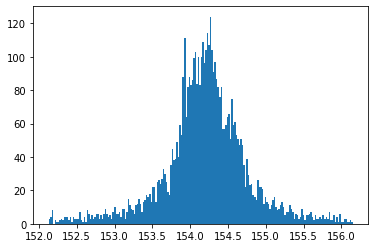

In [153]:
plt.hist(mij1.T[2], bins=200)

(array([  3.,   2.,   1.,   0.,   1.,   0.,   1.,   4.,   1.,   4.,   4.,
          6.,   4.,   6.,   1.,   2.,   2.,   2.,   3.,   7.,   5.,   4.,
          4.,   8.,   1.,   0.,   5.,   6.,   4.,   3.,   6.,   6.,   7.,
          5.,   9.,   5.,   2.,  10.,   4.,   7.,  12.,  13.,   7.,   7.,
          9.,   3.,  16.,  10.,  11.,   5.,  11.,  10.,   8.,  14.,  10.,
         11.,  13.,  13.,  12.,  14.,  18.,  13.,  14.,  11.,  13.,  21.,
         19.,  20.,  12.,  20.,  23.,  27.,  29.,  30.,  35.,  23.,  25.,
         28.,  32.,  31.,  36.,  39.,  38.,  44.,  40.,  59.,  50.,  57.,
         59.,  65.,  78., 116., 160., 139.,  87., 107., 103., 107., 119.,
        113., 125., 117., 127., 132., 121., 150., 144., 157., 156., 156.,
        118., 114.,  92., 123., 116.,  99.,  84., 108.,  89.,  97.,  85.,
         94.,  61.,  79.,  79.,  69.,  73.,  52.,  51.,  55.,  37.,  34.,
         32.,  30.,  23.,  27.,  33.,  18.,  18.,  19.,  19.,  21.,  17.,
         21.,  14.,  10.,  11.,  17., 

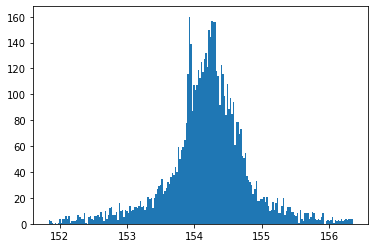

In [154]:
plt.hist(mij2.T[2], bins=200)

In [158]:
M = mij1.mean(axis=0)

In [160]:
M.reshape(3, 3)

array([[ 9.90053328e-01, -8.86546588e-03,  1.54199748e+02],
       [ 2.89164337e-03,  9.92662425e-01,  5.11597140e+01],
       [-2.09567431e-06, -8.81763402e-07,  1.00000000e+00]])

## Image Debug Area

In [102]:
def cvshow(name: str, image: np.ndarray):
    cv.namedWindow(name, cv.WINDOW_NORMAL)
    cv.resizeWindow(name, 1000, 1000)
    cv.moveWindow(name, 130, 20)
    cv.imshow(name, image)

In [103]:
rtimg = cv.cvtColor(
    (refe_gray * (np.iinfo(np.uint8).max / np.iinfo(np.uint16).max)).astype(np.uint8),
    cv.COLOR_GRAY2BGR,
)
for c in tuple(e[0] for e in refe_stars):
    cv.drawMarker(rtimg, tuple(int(e) for e in c), (0, 0, 255))

In [104]:
ttimg = cv.cvtColor(
    (targ_gray * (np.iinfo(np.uint8).max / np.iinfo(np.uint16).max)).astype(np.uint8),
    cv.COLOR_GRAY2BGR,
)
for c in tuple(e[0] for e in targ_stars):
    cv.drawMarker(ttimg, tuple(int(e) for e in c), (0, 0, 255))

In [161]:
# cvshow('refe_photo', refe_photo)
# cvshow('refe_photo_g', refe_photo_g)
# [1844:2044, 1844:2044]
# [1744:2144, 1744:2144]
# [1444:2444, 1444:2444]


# cvshow('refe gray', refe_gray)
cvshow('refe wlred', refe_wlred)
cvshow('rtimg', rtimg)

# cvshow('targ gray', targ_gray)
cvshow('targ wlred', targ_wlred)
cvshow('ttimg', ttimg)


# [2500:2550, 125:175]
# cvshow('refe gray', refe_gray[1175:1425,3325:3575])
cvshow('refe wlred', refe_wlred[1175:1425,3325:3575])
cvshow('rtimg', rtimg[1175:1425,3325:3575])

# cvshow('targ gray', targ_gray[1140:1390,3260:3510])
cvshow('targ wlred', targ_wlred[1140:1390,3260:3510])
cvshow('ttimg', ttimg[1140:1390,3260:3510])


cv.waitKey(0)
cv.destroyAllWindows()

In [171]:
targ.shape

(3888, 3888, 3)

In [175]:
cvshow('targ', targ)
cvshow('targ transformed', cv.warpPerspective(targ, M.reshape(3, 3), targ.shape[:2]))
cvshow('refe', refe)


cv.waitKey(0)
cv.destroyAllWindows()

In [173]:
cv.waitKey(0)
cv.destroyAllWindows()